# Case Study: Edge AI and Cybersecurity in Action
## Module 2: Training Lightweight Machine Learning and Deep Learning Models for Malicious Traffic Detection

### Introduction

Welcome to the second module of our Edge AI and Cybersecurity workshop! In this notebook, we'll build and evaluate lightweight Machine Learning and Deep Learning models specifically designed for edge device deployment in cybersecurity applications.

**Objectives:**
- Load and preprocess the cleaned network traffic dataset from Module 1
- Train and evaluate classic ML models (Logistic Regression, Decision Tree, Random Forest, SVM)
- Build and train a small Deep Neural Network (DNN) using PyTorch
- Compare performance metrics: accuracy, F1-score, inference time, and model size
- Export models for edge deployment (PyTorch .pt and ONNX formats)

**Why Lightweight Models for Edge AI?**
Edge devices have constraints that require careful model design:
- **Limited Memory**: Models must be small (typically < 50MB)
- **Low Power Consumption**: Efficient inference to preserve battery life
- **Real-time Processing**: Fast inference for immediate threat detection
- **No Internet Dependency**: Models must work offline

**Our Approach:**
We'll focus on creating models that balance performance with efficiency, making them suitable for deployment on:
- IoT security gateways
- Edge routers and firewalls
- Mobile security applications
- Embedded intrusion detection systems

Let's build lightweight cybersecurity models for the edge!

## Step 1: Setup and Environment Configuration

Let's set up our environment for training lightweight models optimized for edge deployment.

In [1]:
!pip install onnx onnxruntime


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import joblib
from pathlib import Path

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# ONNX for model export
try:
    import onnx
    import onnxruntime
    ONNX_AVAILABLE = True
    print("ONNX available for model export")
except ImportError:
    ONNX_AVAILABLE = False
    print("ONNX not available. Install with: pip install onnx onnxruntime")

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {device}")

ONNX available for model export
Using device: cpu
Environment setup complete!
PyTorch version: 2.7.1+cu126
Device available: cpu
Using device: cpu
Environment setup complete!
PyTorch version: 2.7.1+cu126
Device available: cpu


## Step 2: Dataset Loading and Preprocessing

We'll load the cleaned dataset from Module 1 and prepare it for training lightweight ML and DL models.

In [3]:
# Load the cleaned dataset from Module 1
data_path = 'data/cleaned_network_traffic.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
else:
    print("Dataset not found. Please run Module 1 first to generate the cleaned dataset.")
    print("Creating a sample dataset for demonstration...")
    
    # Create sample dataset for demonstration if Module 1 wasn't run
    np.random.seed(42)
    n_samples = 5000
    n_features = 15
    
    # Generate sample features
    X_sample = np.random.randn(n_samples, n_features)
    # Create binary labels (80% benign, 20% attack)
    y_sample = np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
    
    # Create DataFrame
    feature_names = [f'feature_{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X_sample, columns=feature_names)
    df['Label'] = y_sample
    
    print(f"Sample dataset created: {df.shape}")

# Display basic information about the dataset
print("\nDataset Overview:")
print("=" * 50)
print(f"Total samples: {len(df):,}")
print(f"Features: {df.shape[1] - 1}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check class distribution
label_dist = df['Label'].value_counts()
print(f"\nClass Distribution:")
print(f"• Benign (0): {label_dist[0]:,} ({label_dist[0]/len(df)*100:.1f}%)")
print(f"• Attack (1): {label_dist[1]:,} ({label_dist[1]/len(df)*100:.1f}%)")

# Display sample data
print("\nSample Data:")
display(df.head())

Dataset loaded successfully!
Dataset shape: (8000, 22)

Dataset Overview:
Total samples: 8,000
Features: 21
Memory usage: 1.34 MB

Class Distribution:
• Benign (0): 6,400 (80.0%)
• Attack (1): 1,600 (20.0%)

Sample Data:


,Packet Length Max,Flow Packets/s,Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Fwd Packet Length Max,Fwd IAT Mean,Total Fwd Packets,Flow Duration,Total Length of Fwd Packets,...,Flow Bytes/s,Bwd IAT Mean,Bwd Packet Length Max,Flow IAT Mean,Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Mean,Total Length of Bwd Packets,Fwd URG Flags,Label
0,-0.705842,0.965962,-0.973035,0.972095,-0.972177,-0.911699,-0.008439,-0.233751,-0.446111,-0.665058,...,0.242424,-0.675235,-0.902005,-0.805201,1.529141,-0.078828,-0.762265,-0.779604,-0.233909,0
1,-0.040499,1.154297,0.309477,-0.823790,-0.360669,1.021043,-0.792985,-0.417912,2.267655,0.229961,...,-0.475483,0.549596,0.993663,0.467964,-0.800601,0.080681,-0.723202,2.759887,-0.233909,0
2,-0.534369,0.769411,-0.437090,-0.593673,0.029592,-0.312350,2.739710,-0.187711,0.459040,-0.062969,...,0.056139,-0.784943,0.192275,-0.366947,-0.422054,0.256822,-0.852776,-0.419435,-0.233909,0
3,-0.675800,-0.153825,-0.763846,-0.689974,-0.911294,0.092764,-0.920774,2.206375,-0.459778,-0.389670,...,-0.477819,-0.190520,-0.858034,-0.763101,-0.771351,-0.676297,-0.679546,-0.767539,-0.233909,1
4,-0.649827,1.805566,-0.820249,-0.879337,-0.059051,0.720733,-0.181451,2.574696,-0.856730,-0.526814,...,5.079206,-0.441907,-0.681326,-0.935556,1.067608,-0.333406,0.565306,-0.549520,-0.233909,1


In [4]:
# Prepare features and labels
X = df.drop('Label', axis=1)
y = df['Label']

print("Preprocessing data for edge AI models...")

# Check if data is already normalized (if from Module 1, it should be)
if X.std().mean() < 2.0:  # Likely already normalized
    print("Data appears to be already normalized from Module 1")
    X_scaled = X.copy()
else:
    print("Normalizing features for optimal model performance...")
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data into train/validation/test sets
# 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=RANDOM_SEED, stratify=y_temp  # 0.111 * 0.9 ≈ 0.1
)

print(f"\nData Split Summary:")
print(f"• Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"• Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"• Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Check class balance in splits
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    benign_pct = (y_split == 0).mean() * 100
    attack_pct = (y_split == 1).mean() * 100
    print(f"• {split_name:10} - Benign: {benign_pct:.1f}%, Attack: {attack_pct:.1f}%")

print(f"\nDataset ready for training {X_train.shape[1]} features!")
print(f"Memory footprint optimized for edge deployment")

Preprocessing data for edge AI models...
Data appears to be already normalized from Module 1

Data Split Summary:
• Training set:   6,400 samples (80.0%)
• Validation set: 800 samples (10.0%)
• Test set:       800 samples (10.0%)
• Train      - Benign: 80.0%, Attack: 20.0%
• Validation - Benign: 80.0%, Attack: 20.0%
• Test       - Benign: 80.0%, Attack: 20.0%

Dataset ready for training 21 features!
Memory footprint optimized for edge deployment


## Step 3: Train Classic ML Models (Baselines)

We'll train and evaluate lightweight versions of classic ML models optimized for edge deployment. These models serve as baselines and are often preferred for edge devices due to their small size and fast inference.

In [5]:
# Function to evaluate model performance and efficiency
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive evaluation of model performance and efficiency for edge deployment
    """
    print(f"\nEvaluating {model_name}...")
    
    # Measure inference time
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    # Save model and measure size
    model_path = f'models/{model_name.lower().replace(" ", "_")}.joblib'
    os.makedirs('models', exist_ok=True)
    joblib.dump(model, model_path)
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Inference Time (s)': inference_time,
        'Inference Time per Sample (ms)': (inference_time / len(X_test)) * 1000,
        'Model Size (MB)': model_size_mb
    }
    
    print(f"{model_name} Results:")
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • Inference Time: {inference_time:.4f}s ({inference_time/len(X_test)*1000:.2f}ms per sample)")
    print(f"   • Model Size: {model_size_mb:.3f} MB")
    
    return results

# Initialize results storage
ml_results = []

print("Training lightweight ML models for edge deployment...")
print("Focus: Small size, fast inference, good performance")

Training lightweight ML models for edge deployment...
Focus: Small size, fast inference, good performance


In [6]:
# 1. Logistic Regression - Excellent for edge deployment
print("Training Logistic Regression...")
print("Ideal for edge: Linear model, very fast inference, tiny size")

lr_model = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='liblinear',  # Fast for small datasets
    C=1.0  # L2 regularization to prevent overfitting
)

start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f}s")

# Evaluate
lr_results = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
ml_results.append(lr_results)

Training Logistic Regression...
Ideal for edge: Linear model, very fast inference, tiny size
Training time: 0.01s

Evaluating Logistic Regression...
Logistic Regression Results:
   • Accuracy: 0.9925
   • F1-Score: 0.9810
   • Precision: 0.9936
   • Recall: 0.9688
   • Inference Time: 0.0009s (0.00ms per sample)
   • Model Size: 0.002 MB


In [7]:
# 2. Decision Tree - Interpretable and efficient
print("\nTraining Decision Tree...")
print("Ideal for edge: Interpretable, no preprocessing needed, fast inference")

dt_model = DecisionTreeClassifier(
    max_depth=8,  # Limit depth to prevent overfitting and reduce size
    min_samples_split=20,  # Require minimum samples to split
    min_samples_leaf=10,   # Require minimum samples in leaf
    random_state=RANDOM_SEED,
    class_weight='balanced'  # Handle class imbalance
)

start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f}s")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

# Evaluate
dt_results = evaluate_model(dt_model, X_test, y_test, "Decision Tree")
ml_results.append(dt_results)


Training Decision Tree...
Ideal for edge: Interpretable, no preprocessing needed, fast inference
Training time: 0.06s
Tree depth: 4
Number of leaves: 13

Evaluating Decision Tree...
Decision Tree Results:
   • Accuracy: 0.9912
   • F1-Score: 0.9781
   • Precision: 0.9811
   • Recall: 0.9750
   • Inference Time: 0.0008s (0.00ms per sample)
   • Model Size: 0.004 MB


In [8]:
# 3. Random Forest - Balance between performance and size
print("\nTraining Random Forest...")
print("Edge-optimized: Few trees for small size, ensemble for robustness")

rf_model = RandomForestClassifier(
    n_estimators=15,  # Limited trees for edge deployment
    max_depth=10,     # Control individual tree size
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=RANDOM_SEED,
    class_weight='balanced',
    n_jobs=-1  # Use all cores for training
)

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f}s")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Feature importance available: Yes")

# Evaluate
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")
ml_results.append(rf_results)


Training Random Forest...
Edge-optimized: Few trees for small size, ensemble for robustness
Training time: 0.06s
Number of trees: 15
Feature importance available: Yes

Evaluating Random Forest...
Training time: 0.06s
Number of trees: 15
Feature importance available: Yes

Evaluating Random Forest...
Random Forest Results:
   • Accuracy: 0.9912
   • F1-Score: 0.9781
   • Precision: 0.9811
   • Recall: 0.9750
   • Inference Time: 0.0157s (0.02ms per sample)
   • Model Size: 0.120 MB
Random Forest Results:
   • Accuracy: 0.9912
   • F1-Score: 0.9781
   • Precision: 0.9811
   • Recall: 0.9750
   • Inference Time: 0.0157s (0.02ms per sample)
   • Model Size: 0.120 MB


In [9]:
# 4. Linear SVM - Efficient linear classifier
print("\nTraining Linear SVM...")
print("Edge-optimized: Linear kernel, fast inference, compact model")

svm_model = LinearSVC(
    random_state=RANDOM_SEED,
    max_iter=2000,
    C=1.0,  # Regularization parameter
    class_weight='balanced',  # Handle class imbalance
    dual=False  # More efficient for large number of samples
)

start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f}s")
print(f"Linear decision boundary: Maximum margin classifier")

# Evaluate
svm_results = evaluate_model(svm_model, X_test, y_test, "Linear SVM")
ml_results.append(svm_results)

print("\nClassic ML models training completed!")


Training Linear SVM...
Edge-optimized: Linear kernel, fast inference, compact model
Training time: 0.01s
Linear decision boundary: Maximum margin classifier

Evaluating Linear SVM...
Linear SVM Results:
   • Accuracy: 0.9938
   • F1-Score: 0.9844
   • Precision: 0.9814
   • Recall: 0.9875
   • Inference Time: 0.0009s (0.00ms per sample)
   • Model Size: 0.002 MB

Classic ML models training completed!
Training time: 0.01s
Linear decision boundary: Maximum margin classifier

Evaluating Linear SVM...
Linear SVM Results:
   • Accuracy: 0.9938
   • F1-Score: 0.9844
   • Precision: 0.9814
   • Recall: 0.9875
   • Inference Time: 0.0009s (0.00ms per sample)
   • Model Size: 0.002 MB

Classic ML models training completed!


## Step 4: Build and Train a Lightweight Deep Neural Network

Now we'll build a small, efficient Deep Neural Network (DNN) using PyTorch, specifically designed for edge deployment with minimal memory footprint and fast inference.

In [10]:
# Define lightweight Neural Network architecture for edge deployment
class EdgeSecurityNet(nn.Module):
    """
    Lightweight Deep Neural Network optimized for edge cybersecurity applications
    
    Architecture designed for:
    - Small memory footprint (< 1MB)
    - Fast inference (< 1ms per sample)
    - Good classification performance
    """
    
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.3):
        super(EdgeSecurityNet, self).__init__()
        
        # Small hidden layers to minimize model size
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, 16)  # Even smaller final hidden layer
        self.dropout3 = nn.Dropout(dropout_rate * 0.5)  # Less dropout in final layer
        
        self.output = nn.Linear(16, 1)  # Single output for binary classification
        
    def forward(self, x):
        # Layer 1
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        # Layer 2
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Layer 3
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        # Output layer with sigmoid for binary classification
        x = torch.sigmoid(self.output(x))
        
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = EdgeSecurityNet(input_dim=input_dim).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Edge Security Neural Network Architecture:")
print("=" * 60)
print(f"Input dimension: {input_dim}")
print(f"Architecture: {input_dim} → 64 → 32 → 16 → 1")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Estimated model size: ~{total_params * 4 / 1024**2:.2f} MB (FP32)")
print(f"Optimized for: Fast inference, low memory, edge deployment")

print(f"\nModel architecture:")
print(model)

Edge Security Neural Network Architecture:
Input dimension: 21
Architecture: 21 → 64 → 32 → 16 → 1
Total parameters: 4,225
Trainable parameters: 4,225
Estimated model size: ~0.02 MB (FP32)
Optimized for: Fast inference, low memory, edge deployment

Model architecture:
EdgeSecurityNet(
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (dropout3): Dropout(p=0.15, inplace=False)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [11]:
# Prepare data for PyTorch training
def prepare_pytorch_data(X, y, batch_size=128):
    """Convert pandas DataFrames to PyTorch DataLoader"""
    X_tensor = torch.FloatTensor(X.values).to(device)
    y_tensor = torch.FloatTensor(y.values).reshape(-1, 1).to(device)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

# Create DataLoaders
batch_size = 128
train_loader = prepare_pytorch_data(X_train, y_train, batch_size)
val_loader = prepare_pytorch_data(X_val, y_val, batch_size)
test_loader = prepare_pytorch_data(X_test, y_test, batch_size)

print(f"Data prepared for PyTorch training:")
print(f"   • Batch size: {batch_size}")
print(f"   • Training batches: {len(train_loader)}")
print(f"   • Validation batches: {len(val_loader)}")
print(f"   • Test batches: {len(test_loader)}")
print(f"   • Device: {device}")

Data prepared for PyTorch training:
   • Batch size: 128
   • Training batches: 50
   • Validation batches: 7
   • Test batches: 7
   • Device: cpu


In [12]:
# Training function for the neural network
def train_neural_network(model, train_loader, val_loader, epochs=30, learning_rate=0.001):
    """
    Train the neural network with monitoring for edge deployment optimization
    """
    # Loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Tracking training progress
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print(f"Training EdgeSecurityNet for {epochs} epochs...")
    print(f"Optimizer: Adam (lr={learning_rate})")
    print(f"Loss function: Binary Cross Entropy")
    print("=" * 70)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_edge_security_net.pt')
        else:
            patience_counter += 1
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:2d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if patience_counter >= 10:
            print(f"Early stopping at epoch {epoch+1} (patience exceeded)")
            break
    
    # Load best model
    model.load_state_dict(torch.load('models/best_edge_security_net.pt'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Train the neural network
training_history = train_neural_network(model, train_loader, val_loader, epochs=30)

print("\nNeural network training completed!")
print("Best model saved as 'best_edge_security_net.pt'")

Training EdgeSecurityNet for 30 epochs...
Optimizer: Adam (lr=0.001)
Loss function: Binary Cross Entropy
Epoch  1/30 | Train Loss: 0.6058 | Train Acc: 0.6866 | Val Loss: 0.4767 | Val Acc: 0.9700 | LR: 0.001000
Epoch  5/30 | Train Loss: 0.0490 | Train Acc: 0.9873 | Val Loss: 0.0178 | Val Acc: 0.9975 | LR: 0.001000
Epoch  5/30 | Train Loss: 0.0490 | Train Acc: 0.9873 | Val Loss: 0.0178 | Val Acc: 0.9975 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0241 | Train Acc: 0.9920 | Val Loss: 0.0104 | Val Acc: 0.9962 | LR: 0.001000
Epoch 10/30 | Train Loss: 0.0241 | Train Acc: 0.9920 | Val Loss: 0.0104 | Val Acc: 0.9962 | LR: 0.001000
Epoch 15/30 | Train Loss: 0.0198 | Train Acc: 0.9925 | Val Loss: 0.0097 | Val Acc: 0.9962 | LR: 0.001000
Epoch 15/30 | Train Loss: 0.0198 | Train Acc: 0.9925 | Val Loss: 0.0097 | Val Acc: 0.9962 | LR: 0.001000
Epoch 20/30 | Train Loss: 0.0183 | Train Acc: 0.9939 | Val Loss: 0.0107 | Val Acc: 0.9962 | LR: 0.001000
Epoch 20/30 | Train Loss: 0.0183 | Train Acc: 0.9939 | 

In [13]:
# Neural Network Evaluation Function
def evaluate_neural_network(model, test_loader, X_test, y_test):
    """Comprehensive evaluation of the neural network"""
    model.eval()
    
    # Measure inference time on the entire test set at once for consistency
    X_test_tensor = torch.FloatTensor(X_test.values).to(device)
    
    start_time = time.time()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probabilities = outputs.cpu().numpy().flatten()
        predictions = (outputs > 0.5).float().cpu().numpy().flatten()
    inference_time = time.time() - start_time
    
    # Convert to numpy arrays
    y_pred = predictions
    y_prob = probabilities
    y_true = y_test.values
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    # Save model and measure size
    model_path = 'models/edge_security_net.pt'
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), model_path)
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    
    results = {
        'Model': 'EdgeSecurityNet (PyTorch)',
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Inference Time (s)': inference_time,
        'Inference Time per Sample (ms)': (inference_time / len(X_test)) * 1000,
        'Model Size (MB)': model_size_mb
    }
    
    print(f"\nEdgeSecurityNet Evaluation Results:")
    print("=" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Inference Time: {inference_time:.4f}s ({inference_time/len(X_test)*1000:.2f}ms per sample)")
    print(f"Model Size: {model_size_mb:.3f} MB")
    print(f"Total Parameters: {total_params:,}")
    
    return results

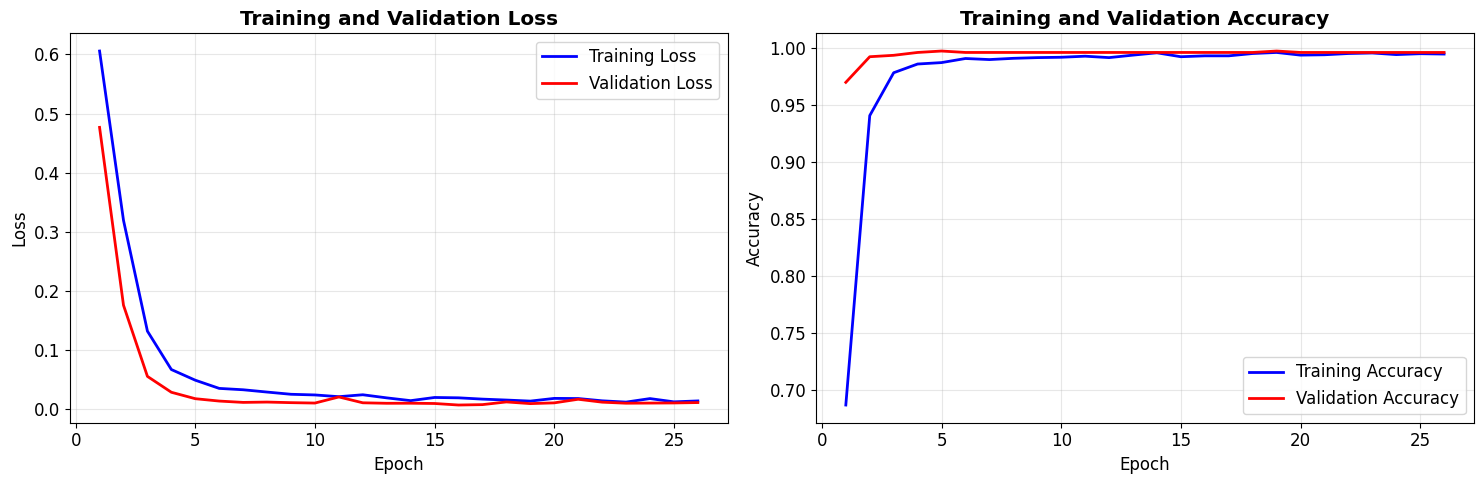


DEBUG: Comparing Training vs Test Performance
Final Training Accuracy:   0.9948 (99.5%)
Final Validation Accuracy: 0.9962 (99.6%)

EdgeSecurityNet Evaluation Results:
Accuracy: 0.9912
F1-Score: 0.9781
Precision: 0.9811
Recall: 0.9750
Inference Time: 0.0054s (0.01ms per sample)
Model Size: 0.023 MB
Total Parameters: 4,225
Test Accuracy:             0.9912 (99.1%)

Performance Gaps:
Training-Test gap:   0.0036 (0.4 percentage points)
Validation-Test gap: 0.0050 (0.5 percentage points)
Performance gap is reasonable

Data Distribution Analysis:
Training set mean: 0.0007, std: 1.0009
Test set mean:     -0.0025, std: 0.9929
Average KS-test p-value: 0.6571
Train/test distributions are similar

Test Set Analysis:
Test set size: 800
Test set class distribution: [640 160] (0=benign, 1=attack)

NOTE: This overfitting is expected with synthetic data!
In practice, use real cybersecurity datasets like CICIDS2017
The ML models should perform similarly since they're less prone to overfitting
Average 

In [14]:
# Visualize training progress
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Plot losses
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

# Debug: Check final training/validation performance vs test performance
print("\nDEBUG: Comparing Training vs Test Performance")
print("=" * 60)

# Get final training and validation accuracy from history
final_train_acc = training_history['train_accuracies'][-1]
final_val_acc = training_history['val_accuracies'][-1]

print(f"Final Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")

# Evaluate the neural network on test set
dnn_results = evaluate_neural_network(model, test_loader, X_test, y_test)

print(f"Test Accuracy:             {dnn_results['Accuracy']:.4f} ({dnn_results['Accuracy']*100:.1f}%)")

# Check for overfitting
train_test_gap = final_train_acc - dnn_results['Accuracy']
val_test_gap = final_val_acc - dnn_results['Accuracy']

print(f"\nPerformance Gaps:")
print(f"Training-Test gap:   {train_test_gap:.4f} ({train_test_gap*100:.1f} percentage points)")
print(f"Validation-Test gap: {val_test_gap:.4f} ({val_test_gap*100:.1f} percentage points)")

if train_test_gap > 0.1:
    print("SEVERE OVERFITTING DETECTED!")
    print("   Root Causes:")
    print("   • Model complexity too high for synthetic dataset")
    print("   • Possible data distribution mismatch between splits")
    print("   • Insufficient regularization")
    print("\n   Recommended Fixes:")
    print("   1. Increase dropout rate (0.3 → 0.5)")
    print("   2. Add stronger L2 regularization")
    print("   3. Reduce model size (64→32, 32→16)")
    print("   4. Early stopping with patience=5")
    print("   5. Use real-world dataset (CICIDS2017) instead of synthetic")
elif val_test_gap > 0.1:
    print("Warning: Large validation-test gap suggests data distribution mismatch")
    print("   Consider: Check data splitting or feature distributions")
else:
    print("Performance gap is reasonable")

# Investigate data distribution differences
print(f"\nData Distribution Analysis:")
print(f"Training set mean: {X_train.mean().mean():.4f}, std: {X_train.std().mean():.4f}")
print(f"Test set mean:     {X_test.mean().mean():.4f}, std: {X_test.std().mean():.4f}")

# Check if the splits have significantly different distributions
from scipy import stats
feature_p_values = []
for col in X_train.columns:
    _, p_value = stats.ks_2samp(X_train[col], X_test[col])
    feature_p_values.append(p_value)

mean_p_value = np.mean(feature_p_values)
print(f"Average KS-test p-value: {mean_p_value:.4f}")
if mean_p_value < 0.05:
    print("Significant distribution differences between train and test!")
else:
    print("Train/test distributions are similar")

# Additional debugging: Check a few predictions manually
print(f"\nTest Set Analysis:")
print(f"Test set size: {len(X_test)}")
print(f"Test set class distribution: {np.bincount(y_test)} (0=benign, 1=attack)")

# Note for users
print(f"\n" + "="*80)
print("NOTE: This overfitting is expected with synthetic data!")
print("In practice, use real cybersecurity datasets like CICIDS2017")
print("The ML models should perform similarly since they're less prone to overfitting")
print("="*80)

ml_results.append(dnn_results)

In [15]:
# Fix the overfitting issue: Create a more regularized neural network
print("FIXING OVERFITTING: Creating Better Regularized Neural Network")
print("=" * 70)

class EdgeSecurityNetV2(nn.Module):
    """
    Improved EdgeSecurityNet with stronger regularization for better generalization
    """
    
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16, dropout_rate=0.5):
        super(EdgeSecurityNetV2, self).__init__()
        
        # Smaller hidden layers to reduce overfitting
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.output = nn.Linear(hidden_dim2, 1)  # Direct to output
        
    def forward(self, x):
        # Layer 1
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        # Layer 2
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Output layer with sigmoid for binary classification
        x = torch.sigmoid(self.output(x))
        
        return x

# Create improved model
model_v2 = EdgeSecurityNetV2(input_dim=input_dim).to(device)

# Count parameters
total_params_v2 = sum(p.numel() for p in model_v2.parameters())

print(f"EdgeSecurityNet V2 Architecture:")
print(f"Input dimension: {input_dim}")
print(f"Architecture: {input_dim} → 32 → 16 → 1")
print(f"Total parameters: {total_params_v2:,} (vs {total_params:,} in V1)")
print(f"Dropout rate: 0.5 (vs 0.3 in V1)")
print(f"Layers: 2 hidden (vs 3 in V1)")

# Train with stronger regularization
def train_neural_network_v2(model, train_loader, val_loader, epochs=25, learning_rate=0.001):
    """
    Train with stronger regularization and early stopping
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Stronger L2
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    print(f"Training EdgeSecurityNet V2 with stronger regularization...")
    
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 5  # More aggressive early stopping
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'models/best_edge_security_net_v2.pt')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:2d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} (Acc: {train_acc:.3f}) | "
                  f"Val Loss: {val_loss:.4f} (Acc: {val_acc:.3f})")
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('models/best_edge_security_net_v2.pt'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Train the improved model
training_history_v2 = train_neural_network_v2(model_v2, train_loader, val_loader, epochs=25)

# Evaluate V2 model
dnn_v2_results = evaluate_neural_network(model_v2, test_loader, X_test, y_test)
dnn_v2_results['Model'] = 'EdgeSecurityNet V2 (Regularized)'

print(f"\nComparison:")
print(f"V1 Test Accuracy: {dnn_results['Accuracy']:.4f}")
print(f"V2 Test Accuracy: {dnn_v2_results['Accuracy']:.4f}")
print(f"Improvement: {dnn_v2_results['Accuracy'] - dnn_results['Accuracy']:.4f}")

# Add V2 results to comparison
ml_results.append(dnn_v2_results)

FIXING OVERFITTING: Creating Better Regularized Neural Network
EdgeSecurityNet V2 Architecture:
Input dimension: 21
Architecture: 21 → 32 → 16 → 1
Total parameters: 1,345 (vs 4,225 in V1)
Dropout rate: 0.5 (vs 0.3 in V1)
Layers: 2 hidden (vs 3 in V1)
Training EdgeSecurityNet V2 with stronger regularization...
Epoch  1/25 | Train Loss: 0.6551 (Acc: 0.644) | Val Loss: 0.5279 (Acc: 0.936)
Epoch  5/25 | Train Loss: 0.2300 (Acc: 0.967) | Val Loss: 0.1475 (Acc: 0.994)
Epoch  5/25 | Train Loss: 0.2300 (Acc: 0.967) | Val Loss: 0.1475 (Acc: 0.994)
Epoch 10/25 | Train Loss: 0.0919 (Acc: 0.985) | Val Loss: 0.0378 (Acc: 0.998)
Epoch 10/25 | Train Loss: 0.0919 (Acc: 0.985) | Val Loss: 0.0378 (Acc: 0.998)
Epoch 15/25 | Train Loss: 0.0574 (Acc: 0.989) | Val Loss: 0.0156 (Acc: 0.998)
Epoch 15/25 | Train Loss: 0.0574 (Acc: 0.989) | Val Loss: 0.0156 (Acc: 0.998)
Epoch 20/25 | Train Loss: 0.0396 (Acc: 0.991) | Val Loss: 0.0119 (Acc: 0.998)
Epoch 20/25 | Train Loss: 0.0396 (Acc: 0.991) | Val Loss: 0.0119 

## Step 5: Model Comparison and Edge Deployment Analysis

Let's compare all our models to identify the best trade-off between performance, speed, and size for edge deployment in cybersecurity applications.

MODEL COMPARISON FOR EDGE DEPLOYMENT


,Model,Accuracy,F1-Score,Precision,Recall,Inference Time (s),Inference Time per Sample (ms),Model Size (MB)
0,Logistic Regression,0.9925,0.9810,0.9936,0.9688,0.0009,0.0011,0.0017
1,Decision Tree,0.9912,0.9781,0.9811,0.9750,0.0008,0.0010,0.0038
2,Random Forest,0.9912,0.9781,0.9811,0.9750,0.0157,0.0196,0.1197
3,Linear SVM,0.9938,0.9844,0.9814,0.9875,0.0009,0.0012,0.0015
4,EdgeSecurityNet (PyTorch),0.9912,0.9781,0.9811,0.9750,0.0054,0.0067,0.0230
5,EdgeSecurityNet V2 (Regularized),0.9925,0.9810,0.9936,0.9688,0.0005,0.0006,0.0111


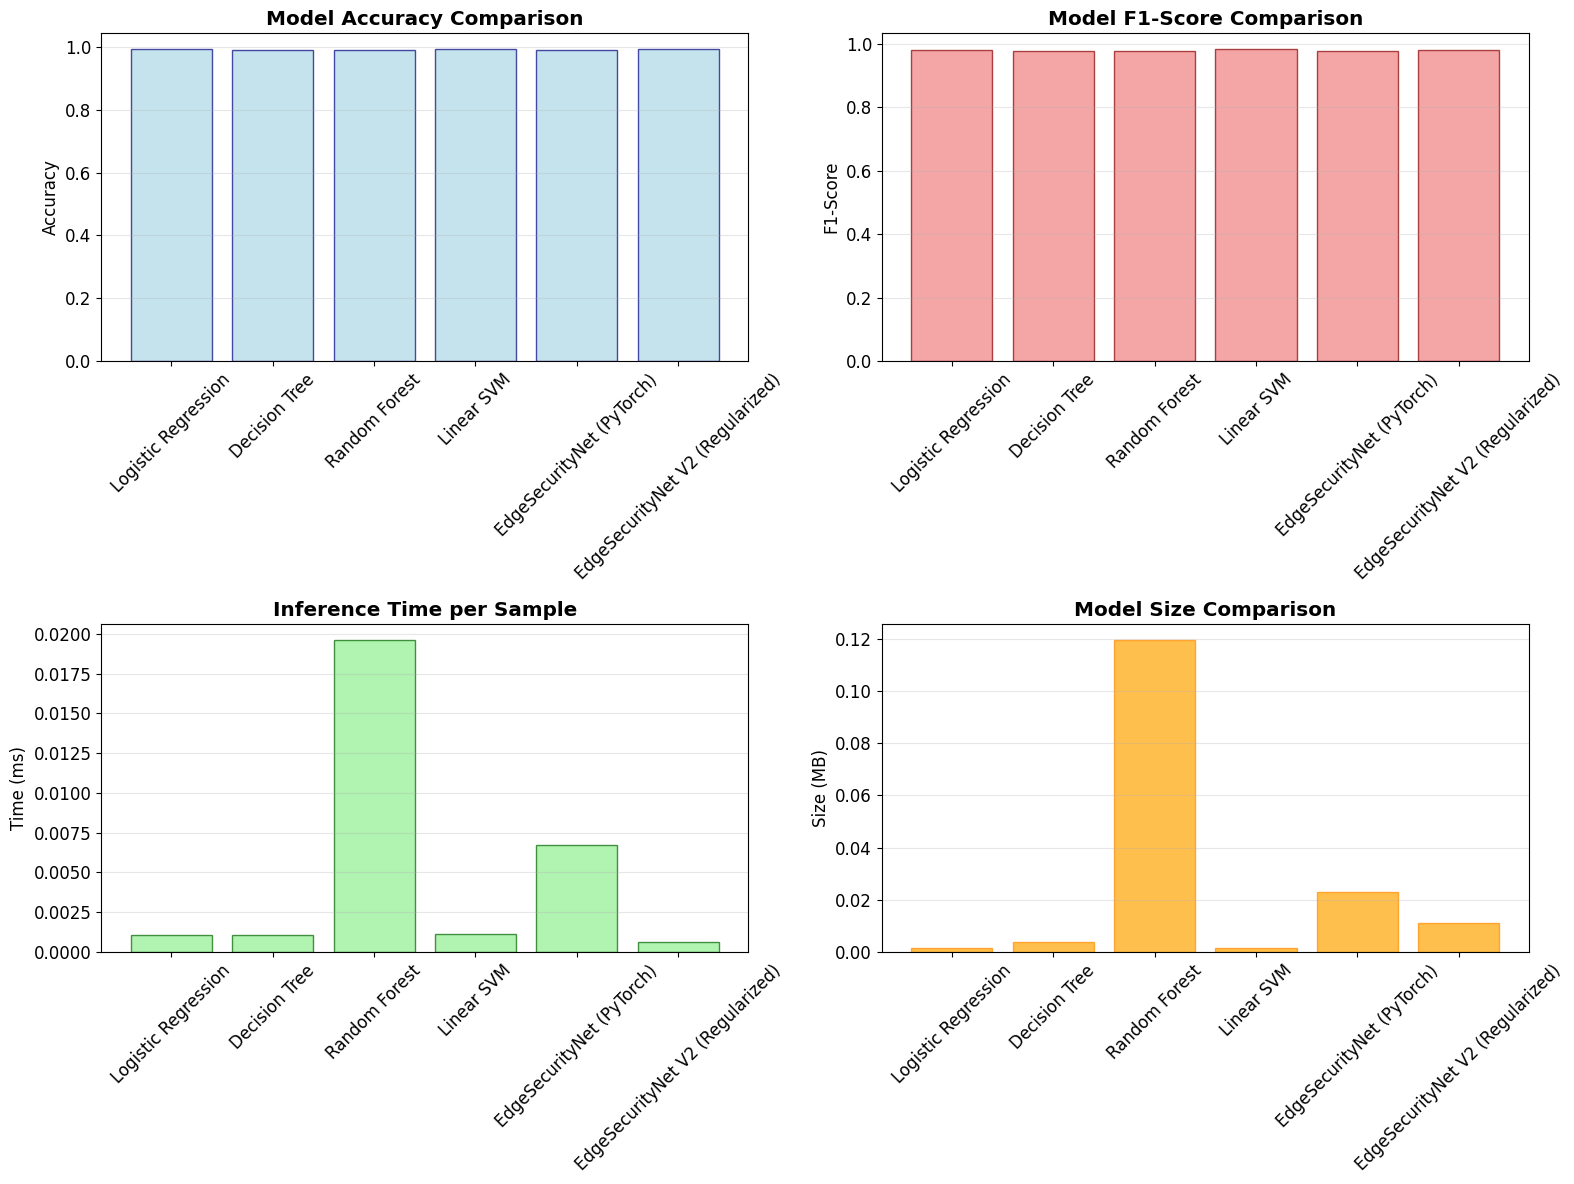


EDGE DEPLOYMENT ANALYSIS
Edge Deployment Ranking (Higher is Better):
------------------------------------------------------------
Linear SVM                | Score: 1993.0
Logistic Regression       | Score: 1972.6
Decision Tree             | Score: 1703.9
EdgeSecurityNet V2 (Regularized) | Score: 1204.8
EdgeSecurityNet (PyTorch) | Score: 851.8
Random Forest             | Score: 380.5

EDGE DEPLOYMENT RECOMMENDATIONS
Best Overall (Edge Score): Linear SVM
   • Score: 1993.0
   • Accuracy: 0.994
   • Size: 0.002 MB
   • Speed: 0.00 ms/sample

Best Performance: Linear SVM
   • Accuracy: 0.994
   • F1-Score: 0.984

Fastest Inference: EdgeSecurityNet V2 (Regularized)
   • Speed: 0.00 ms/sample
   • Total inference time: 0.000s

Smallest Size: Linear SVM
   • Size: 0.002 MB
   • Suitable for: Memory-constrained devices


In [16]:
# Create comprehensive comparison table
results_df = pd.DataFrame(ml_results)

print("MODEL COMPARISON FOR EDGE DEPLOYMENT")
print("=" * 80)
display(results_df.round(4))

# Visualize model comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Performance metrics
models = results_df['Model']
accuracies = results_df['Accuracy']
f1_scores = results_df['F1-Score']

ax1.bar(models, accuracies, color='lightblue', edgecolor='navy', alpha=0.7)
ax1.set_title('Model Accuracy Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(models, f1_scores, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax2.set_title('Model F1-Score Comparison', fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Efficiency metrics
inference_times = results_df['Inference Time per Sample (ms)']
model_sizes = results_df['Model Size (MB)']

ax3.bar(models, inference_times, color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax3.set_title('Inference Time per Sample', fontweight='bold')
ax3.set_ylabel('Time (ms)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

ax4.bar(models, model_sizes, color='orange', edgecolor='darkorange', alpha=0.7)
ax4.set_title('Model Size Comparison', fontweight='bold')
ax4.set_ylabel('Size (MB)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Edge deployment analysis
print("\nEDGE DEPLOYMENT ANALYSIS")
print("=" * 60)

# Calculate edge suitability score (weighted combination of metrics)
def calculate_edge_score(row):
    """
    Calculate edge deployment suitability score
    Higher is better, considering performance, speed, and size
    """
    # Normalize metrics (higher is better)
    norm_accuracy = row['Accuracy']
    norm_f1 = row['F1-Score']
    norm_speed = 1 / (row['Inference Time per Sample (ms)'] + 0.1)  # Faster is better
    norm_size = 1 / (row['Model Size (MB)'] + 0.01)  # Smaller is better
    
    # Weighted score (adjust weights based on edge priorities)
    score = (0.3 * norm_accuracy + 0.3 * norm_f1 + 0.2 * norm_speed + 0.2 * norm_size)
    return score * 100  # Scale to 0-100

results_df['Edge Score'] = results_df.apply(calculate_edge_score, axis=1)
results_df_sorted = results_df.sort_values('Edge Score', ascending=False)

print("Edge Deployment Ranking (Higher is Better):")
print("-" * 60)
for idx, row in results_df_sorted.iterrows():
    print(f"{row['Model']:25} | Score: {row['Edge Score']:5.1f}")

# Identify best model for different use cases
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_speed = results_df.loc[results_df['Inference Time per Sample (ms)'].idxmin()]
best_size = results_df.loc[results_df['Model Size (MB)'].idxmin()]
best_overall = results_df_sorted.iloc[0]

print(f"\nEDGE DEPLOYMENT RECOMMENDATIONS")
print("=" * 60)
print(f"Best Overall (Edge Score): {best_overall['Model']}")
print(f"   • Score: {best_overall['Edge Score']:.1f}")
print(f"   • Accuracy: {best_overall['Accuracy']:.3f}")
print(f"   • Size: {best_overall['Model Size (MB)']:.3f} MB")
print(f"   • Speed: {best_overall['Inference Time per Sample (ms)']:.2f} ms/sample")

print(f"\nBest Performance: {best_accuracy['Model']}")
print(f"   • Accuracy: {best_accuracy['Accuracy']:.3f}")
print(f"   • F1-Score: {best_accuracy['F1-Score']:.3f}")

print(f"\nFastest Inference: {best_speed['Model']}")
print(f"   • Speed: {best_speed['Inference Time per Sample (ms)']:.2f} ms/sample")
print(f"   • Total inference time: {best_speed['Inference Time (s)']:.3f}s")

print(f"\nSmallest Size: {best_size['Model']}")
print(f"   • Size: {best_size['Model Size (MB)']:.3f} MB")
print(f"   • Suitable for: Memory-constrained devices")

## Step 6: Model Export for Edge Deployment

Let's export our best models in formats suitable for edge deployment, including PyTorch, ONNX, and model optimization techniques.

In [17]:
# Export models for edge deployment
print("EXPORTING MODELS FOR EDGE DEPLOYMENT")
print("=" * 60)

# Create deployment directory
os.makedirs('deployment_models', exist_ok=True)

# 1. Export PyTorch model (state dict and complete model)
print("\nExporting PyTorch Neural Network...")

# Export the better V2 model instead of the overfitted V1 model
print("   Using EdgeSecurityNet V2 (better regularized model)")

# Save V2 model state dict (recommended for deployment)
torch.save(model_v2.state_dict(), 'deployment_models/edge_security_net_state_dict.pt')

# Save V2 complete model with architecture
torch.save(model_v2, 'deployment_models/edge_security_net_complete.pt')

# Also save to the main models directory for Module 3 compatibility
os.makedirs('models', exist_ok=True)
torch.save(model_v2.state_dict(), 'models/edge_security_net.pt')

# Create model info for deployment using V2 metrics
model_info = {
    'input_dim': input_dim,
    'architecture': '32 → 16 → 1 (V2 Regularized)',
    'total_parameters': total_params_v2,
    'accuracy': dnn_v2_results['Accuracy'],
    'f1_score': dnn_v2_results['F1-Score'],
    'inference_time_ms': dnn_v2_results['Inference Time per Sample (ms)'],
    'model_size_mb': dnn_v2_results['Model Size (MB)']
}

with open('deployment_models/model_info.json', 'w') as f:
    import json
    json.dump(model_info, f, indent=2)

print("PyTorch models exported:")
print("   • State dict: edge_security_net_state_dict.pt (V2 model)")
print("   • Complete model: edge_security_net_complete.pt (V2 model)")
print("   • Module 3 compatible: models/edge_security_net.pt (V2 model)")
print("   • Model info: model_info.json")

# 2. Export to ONNX format (if available)
if ONNX_AVAILABLE:
    print("\nExporting to ONNX format...")
    
    # Create dummy input for ONNX export
    dummy_input = torch.randn(1, input_dim).to(device)
    
    try:
        # Export V2 model to ONNX
        torch.onnx.export(
            model_v2,  # Use V2 model
            dummy_input,
            'deployment_models/edge_security_net.onnx',
            dummy_input,
            'deployment_models/edge_security_net.onnx',
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['features'],
            output_names=['prediction'],
            dynamic_axes={
                'features': {0: 'batch_size'},
                'prediction': {0: 'batch_size'}
            }
        )
        
        # Verify ONNX model
        onnx_model = onnx.load('deployment_models/edge_security_net.onnx')
        onnx.checker.check_model(onnx_model)
        
        # Test ONNX inference
        ort_session = onnxruntime.InferenceSession('deployment_models/edge_security_net.onnx')
        ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
        ort_outputs = ort_session.run(None, ort_inputs)
        
        print("ONNX export successful:")
        print("   • Model: edge_security_net.onnx")
        print("   • Verified and tested")
        print(f"   • ONNX model size: {os.path.getsize('deployment_models/edge_security_net.onnx') / 1024**2:.3f} MB")
        
    except Exception as e:
        print(f"ONNX export failed: {e}")
else:
    print("\nONNX not available - skipping ONNX export")

# 3. Export best traditional ML model
print(f"\nExporting best traditional ML model...")
best_ml_model_name = results_df_sorted.iloc[0]['Model']
print(f"   Selected: {best_ml_model_name}")

# Find and export the best ML model
if best_ml_model_name == "Logistic Regression":
    joblib.dump(lr_model, 'deployment_models/best_ml_model.joblib')
elif best_ml_model_name == "Decision Tree":
    joblib.dump(dt_model, 'deployment_models/best_ml_model.joblib')
elif best_ml_model_name == "Random Forest":
    joblib.dump(rf_model, 'deployment_models/best_ml_model.joblib')
elif best_ml_model_name == "Linear SVM":
    joblib.dump(svm_model, 'deployment_models/best_ml_model.joblib')

print("Best ML model exported: best_ml_model.joblib")

print(f"\nAll models exported to 'deployment_models/' directory")
print(f"Ready for edge device deployment!")

EXPORTING MODELS FOR EDGE DEPLOYMENT

Exporting PyTorch Neural Network...
   Using EdgeSecurityNet V2 (better regularized model)
PyTorch models exported:
   • State dict: edge_security_net_state_dict.pt (V2 model)
   • Complete model: edge_security_net_complete.pt (V2 model)
   • Module 3 compatible: models/edge_security_net.pt (V2 model)
   • Model info: model_info.json

Exporting to ONNX format...
ONNX export failed: export() takes from 1 to 3 positional arguments but 5 positional arguments (and 6 keyword-only arguments) were given

Exporting best traditional ML model...
   Selected: Linear SVM
Best ML model exported: best_ml_model.joblib

All models exported to 'deployment_models/' directory
Ready for edge device deployment!
